# After running run_many.py, this notebook will reproduce Fig. 2 of 2508.21131

### - Start importing useful libraries

In [1]:
# Global imports
import sys
import jax
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA.angular_decomposition import spherical_harmonics as sph


print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 14,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

cmap = plt.get_cmap("Reds")

/home/pieroni/my_projects/fastPTA_papers/paper_cosmic_variance/fastpta_anisotropies/examples/examples_paper_cosmic_variance/..


### - Simulation setup parameters

In [2]:
l_max = 2  # Maximum multipole order to consider
n_realizations = 1000  # Number of Monte Carlo realizations
npulsars = 500  # Number of pulsars in the array
nside = 8  # HEALPix resolution parameter
nfreqs = 15  # Number of frequency bins

add_dipole = True  # Include dipole contribution
add_quadrupole = False  # Exclude quadrupole contribution

### - Initialize spherical harmonic coefficients

In [3]:
# Spherical harmonic coefficients setup
clms_real = np.zeros(
    sph.get_n_coefficients_real(l_max)
)  # Initialize real spherical harmonic coefficients

clms_real[0] = 1.0  # Monopole term

if add_dipole:
    clms_real[2] = 1.0 / np.sqrt(3)  # Dipole contribution
if add_quadrupole:
    clms_real[6] = np.sqrt(4 * np.pi) / np.sqrt(
        5 * np.pi
    )  # Quadrupole contribution

clms_real /= np.sqrt(4 * np.pi)  # Normalize coefficients

### - Wrappers for Data file handling: naming and loading

In [ ]:
def name(add_dipole, add_quadrupole, n_realizations, npulsars, nside, nfreqs):
    """
    Construct file path for simulation output based on configuration.
    """
    base = "generated_data/ff_"

    # Encode simulation parameters in filename
    to_append = f"{n_realizations}_{npulsars}_{nside}_{nfreqs}"

    if add_dipole:
        to_append = "dipole_" + to_append
    elif add_quadrupole:
        to_append = "quadrupole_" + to_append

    return base + to_append + ".npz"


def load_clean(
    add_dipole, add_quadrupole, n_realizations, npulsars, nside, nfreqs
):
    """
    Load and clean spherical harmonic coefficient data from .npz file.
    Removes entries containing NaNs.
    """
    data = np.load(
        name(
            add_dipole, add_quadrupole, n_realizations, npulsars, nside, nfreqs
        ),
        allow_pickle=True,
    )

    clms = data["means"]  # mean coefficients
    dclms = data["stds"]  # std deviations
    cdfs = data["cdfs"]  # cumulative distributions

    # Filter out rows with NaNs
    cdfs = cdfs[~np.isnan(clms).any(axis=1)]
    dclms = dclms[~np.isnan(clms).any(axis=1)]
    clms = clms[~np.isnan(clms).any(axis=1)]
    cdfs = cdfs[~np.isnan(dclms).any(axis=1)]
    clms = clms[~np.isnan(dclms).any(axis=1)]
    dclms = dclms[~np.isnan(dclms).any(axis=1)]

    return clms, dclms, cdfs

# Plot for figure 3

In [5]:
# Map multipole order l to indices of corresponding c_lm coefficients
l_to_indices = {
    0: [0],
    1: [1, 2, 3],
    2: [4, 5, 6, 7, 8],
    3: [9, 10, 11, 12, 13, 14, 15],
}

colors = ["red", "blue", "green", "purple", "cyan"]  # Plotting colors per l


def compute_Cl(c_lm_vec, l):
    """Compute multipole power C_l = (1 / (2l+1)) Σ_m c_lm^2"""
    indices = l_to_indices[l]
    return np.sum(np.array(c_lm_vec)[indices] ** 2) / (2 * l + 1)


def compute_sigma_Cl(c_lm_unc, c_lm_mean, l):
    """Propagate uncertainties from c_lm to C_l using linear error propagation"""
    indices = l_to_indices[l]
    sigma_sq = 0.0
    for i in indices:
        c = c_lm_mean[i]  # mean coefficient
        sigma = c_lm_unc[i]  # std deviation
        sigma_sq += (2 * c * sigma) ** 2
    return np.sqrt(sigma_sq) / (2 * l + 1)

### - Plot histograms of normalized C_l / sigma_C_l for different injections and number of pulsars

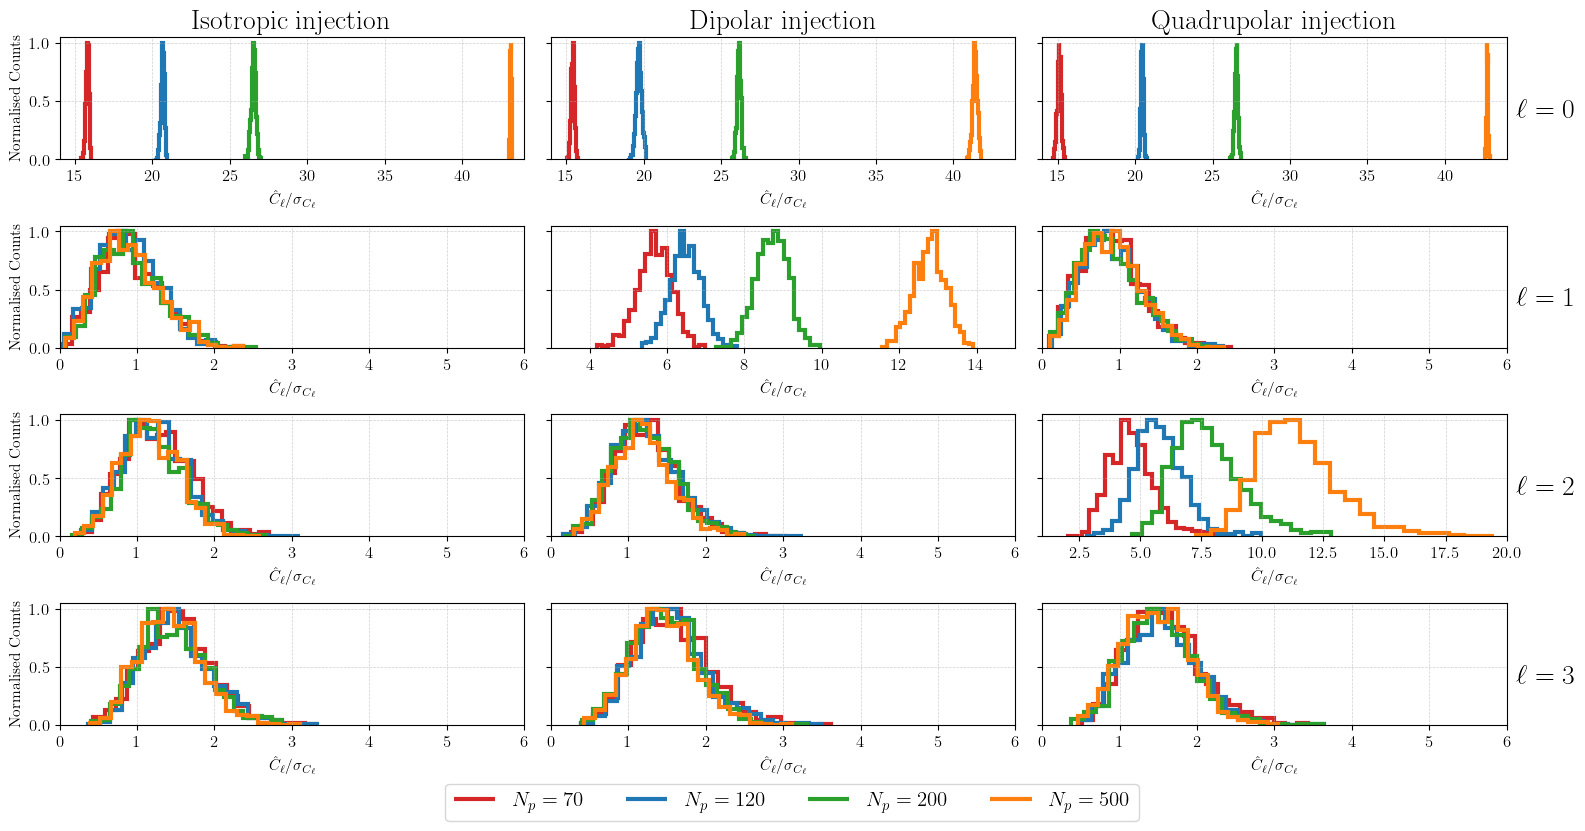

In [ ]:
# Pulsar counts to compare
Np_list = [70, 120, 200, 500]
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange"]

# Labels for multipoles ℓ = 0..3
list_labels = [r"\ell = 0", r"\ell = 1", r"\ell = 2", r"\ell = 3"]

# Injection types: (dipole, quadrupole, title)
configs = [
    (False, False, "Isotropic injection"),
    (True, False, "Dipolar injection"),
    (False, True, "Quadrupolar injection"),
]

# Custom x-axis limits for each ℓ
xlims_per_l = {
    0: (14.0, 44),
    1: (0, 6),
    2: (0, 6),
    3: (0, 6),
}

# Line styles for plotting (here all set solid)
dash_styles = [(0, ()), (0, ()), (0, ()), (0, ())]

# Figure: 4 rows (ℓ = 0..3), 3 cols (configurations)
fig, axes = plt.subplots(4, 3, figsize=(16, 8), sharey=True)
plt.subplots_adjust(hspace=-1.2, wspace=0.05)

for col, (add_dipole, add_quadrupole, title) in enumerate(configs):
    for row, l in enumerate([0, 1, 2, 3]):
        ax = axes[row, col]
        # Loop over different pulsar counts
        for i, (Np, color) in enumerate(zip(Np_list, colors)):
            clms, dclms, cdfs = load_clean(
                add_dipole, add_quadrupole, n_realizations, Np, nside, nfreqs
            )
            # Normalize power spectrum by uncertainty
            Cl_norm = [
                compute_Cl(c, l) / compute_sigma_Cl(s, c, l)
                for c, s in zip(clms, dclms)
            ]
            data = np.array(Cl_norm)
            data_clipped = data[data <= 1e3]  # remove outliers

            # Histogram normalized to max = 1
            counts, bins = np.histogram(data_clipped, bins=20)
            counts = counts / counts.max()
            ax.stairs(
                counts,
                bins,
                label=f"$N_p={Np}$",
                color=color,
                linestyle=dash_styles[i % len(dash_styles)],
                linewidth=3,
            )

            # Axis limits per ℓ (with special cases)
            ax.set_xlim(*xlims_per_l[l])
            ax.set_ylim(0, 1.05)
            if row == 1 and col == 1:
                ax.set_xlim(3, 15)
            if row == 2 and col == 2:
                ax.set_xlim(1, 20)

        # Axis labels and titles
        ax.set_xlabel(r"$\hat C_\ell / \sigma_{C_\ell}$", fontsize=11)
        if col == 0:
            ax.set_ylabel("Normalised Counts", fontsize=11)
        if row == 0:
            ax.set_title(title, fontsize=20)
        if col == 2:
            ax.text(
                1.02,
                0.4,
                rf"${list_labels[row]}$",
                transform=ax.transAxes,
                fontsize=20,
                va="center",
            )
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

# Shared legend across all panels
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(Np_list),
    fontsize=15,
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout()
plt.savefig("plots/Cl_sigma_panels.pdf", bbox_inches="tight")
plt.show();